## Importing Libraries

In [1]:
import pandas as pd                                  
import seaborn as sns                                 
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats                               

from sklearn.preprocessing import LabelEncoder        
from sklearn.model_selection import train_test_split  
from sklearn import metrics                            
from sklearn.linear_model import LinearRegression     
from sklearn.linear_model import Lasso                
from xgboost import XGBRegressor                      

%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

df = pd.read_csv("../input/pizza-price-prediction/pizza_v1.csv")

### Analyzing The Dataset

In [2]:
print(df.shape)
df.head()

(129, 8)


,company,price_rupiah,diameter,topping,variant,size,extra_sauce,extra_cheese
0,A,"Rp235,000",22.0,chicken,double_signature,jumbo,yes,yes
1,A,"Rp198,000",20.0,papperoni,double_signature,jumbo,yes,yes
2,A,"Rp120,000",16.0,mushrooms,double_signature,reguler,yes,yes
3,A,"Rp155,000",14.0,smoked beef,double_signature,reguler,yes,no
4,A,"Rp248,000",18.0,mozzarella,double_signature,jumbo,yes,no


The dataset as 129 rows and 8 columns

The dataset shows us the different variables that are used to determine the price of the pizza

Our target variable is **price_rupiah**


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company       129 non-null    object 
 1   price_rupiah  129 non-null    object 
 2   diameter      129 non-null    float64
 3   topping       129 non-null    object 
 4   variant       129 non-null    object 
 5   size          129 non-null    object 
 6   extra_sauce   129 non-null    object 
 7   extra_cheese  129 non-null    object 
dtypes: float64(1), object(7)
memory usage: 8.2+ KB


The price_rupiah values must need to change to **float or int** and other column values must also need to be changed


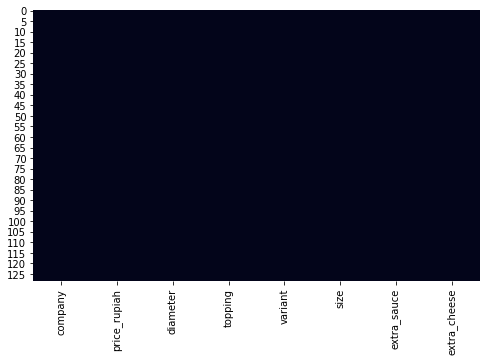

In [4]:
#Checking for null values
sns.heatmap(df.isnull(), cbar = False)
plt.show()

The dataset has **no null values**

### Cleaning the Dataset

**Changing the column price_rupiah value to int or float**

In [5]:
df["price_rupiah"] = df["price_rupiah"].str.replace("Rp","").str.replace(",","")

#Converting the datatype to int
df["price_rupiah"] = df["price_rupiah"].astype(int)

In [6]:
#At the time of making this notebook the converstion price of rupiah to dollars is 0.00070
df["price"] = df["price_rupiah"] * 0.000070

#droping the column price_rupiah
df.drop("price_rupiah", axis = 1, inplace = True)

In [7]:
#Changing the datatype of diameter to int
df["diameter"] = df["diameter"].astype(int)
df.head()

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,price
0,A,22,chicken,double_signature,jumbo,yes,yes,16.45
1,A,20,papperoni,double_signature,jumbo,yes,yes,13.86
2,A,16,mushrooms,double_signature,reguler,yes,yes,8.40
3,A,14,smoked beef,double_signature,reguler,yes,no,10.85
4,A,18,mozzarella,double_signature,jumbo,yes,no,17.36


### Visualizing the Dataset

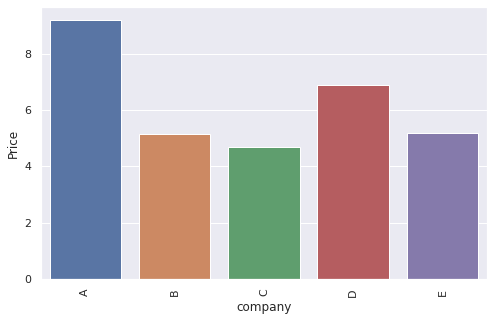

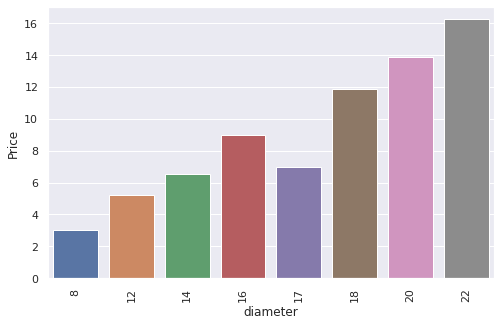

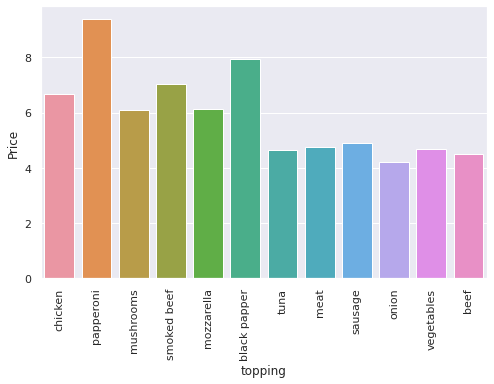

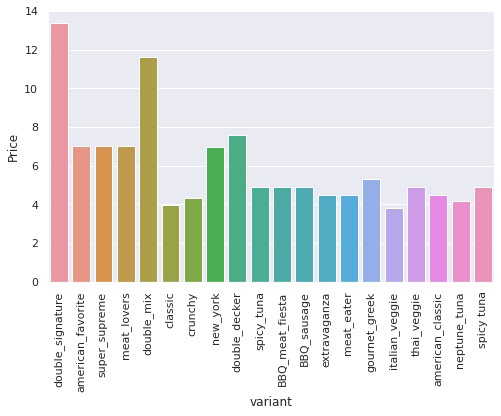

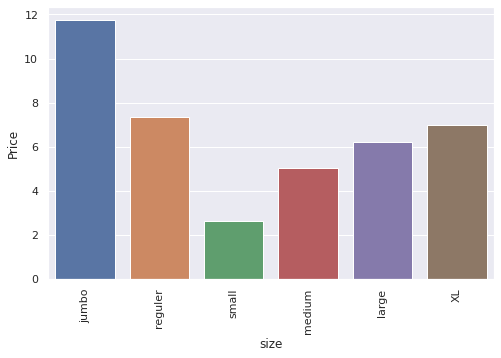

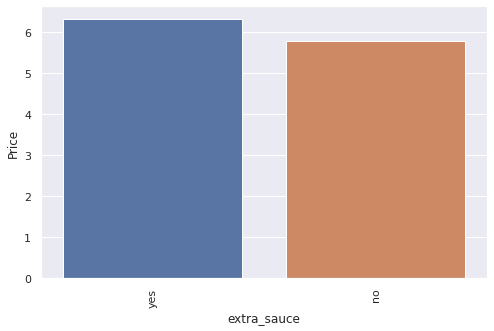

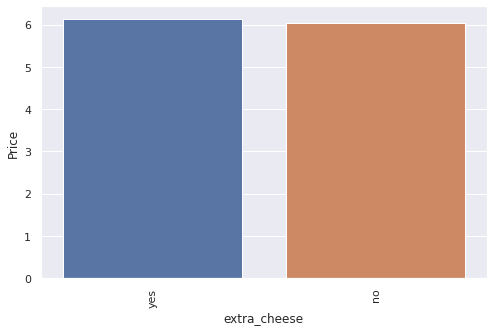

In [8]:
for X in df.columns:
    if X == "price":
        pass
    else:
        sns.set_theme(style="darkgrid")
        sns.barplot(x = X, y = "price", data = df, ci = None)
        plt.xticks(rotation = 90)
        plt.xlabel(X)
        plt.ylabel("Price")
        plt.show()

**The chart shows the different value with respect to the price.**

### Encoding the Dataset

In [9]:
le = LabelEncoder()

In [10]:
#Encoding the cloumns with object datatype
for val in df.columns:
    if df[val].dtype == "O":
        df[val] = le.fit_transform(df[val])
df.head()
        

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,price
0,0,22,2,8,1,1,1,16.45
1,0,20,7,8,1,1,1,13.86
2,0,16,5,8,4,1,1,8.40
3,0,14,9,8,4,1,0,10.85
4,0,18,4,8,1,1,0,17.36


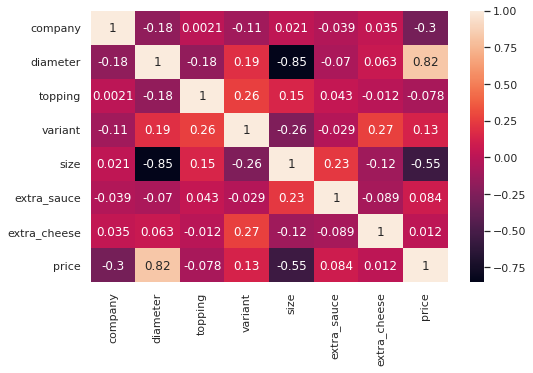

In [11]:
correlation = df.corr()
sns.heatmap(correlation, annot = True)
plt.show()

The correlation chart shows that the **diameter** has the **highest correlation with the price**

In [12]:
df.describe()

,company,diameter,topping,variant,size,extra_sauce,extra_cheese,price
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,2.046512,12.852713,5.294574,8.155039,2.868217,0.589147,0.666667,6.100581
std,1.435381,3.340333,3.204984,5.265527,1.470437,0.493907,0.473242,3.129427
min,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.645000
25%,1.000000,12.000000,2.000000,4.000000,2.000000,0.000000,0.000000,3.570000
50%,2.000000,12.000000,5.000000,6.000000,3.000000,1.000000,1.000000,5.460000
75%,3.000000,14.000000,9.000000,13.000000,4.000000,1.000000,1.000000,7.350000
max,4.000000,22.000000,11.000000,19.000000,5.000000,1.000000,1.000000,17.360000


### Checking for Outliears 

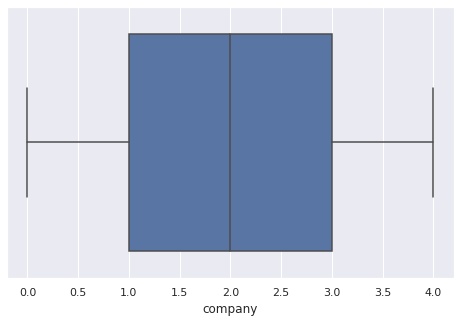

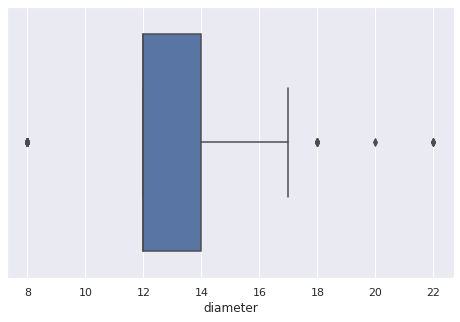

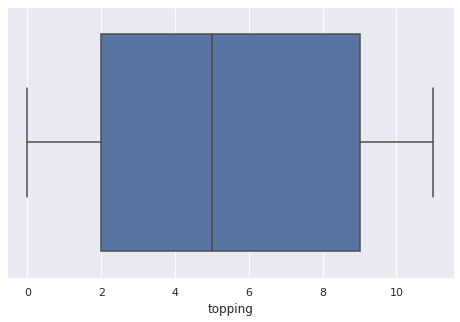

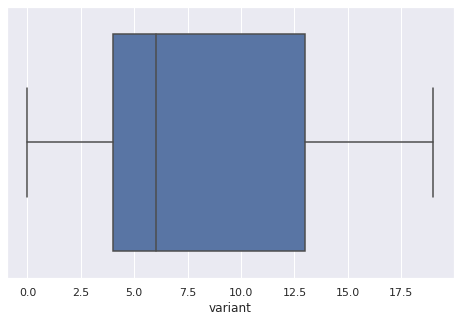

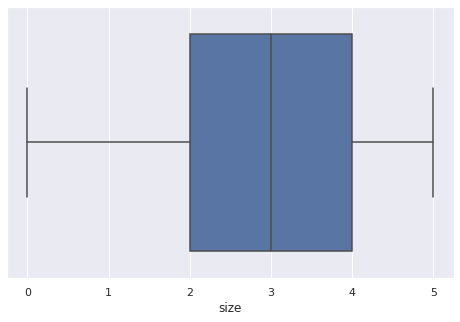

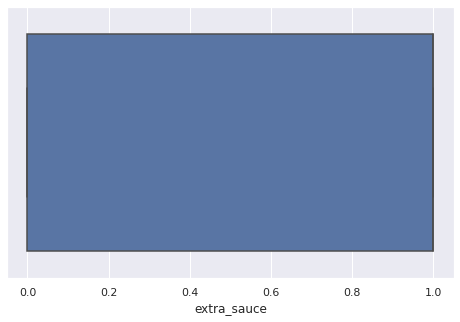

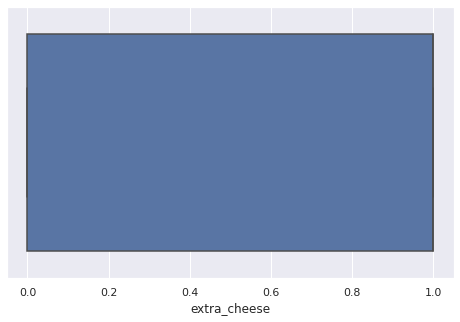

In [13]:
for X in df.columns:
    if X == "price":
        pass
    else:
        sns.boxplot(x = X, data = df)
        plt.show()

The boxplot shows that the diameter has a outlier

### Removing Outliers using IQR

In [14]:
q1 = df["diameter"].quantile(0.25)
q3 = df["diameter"].quantile(0.75)
IQR = q3 - q1

Lower_whisk = q1 - 1.5 * IQR
Upper_whisk = q3 + 1.5 * IQR

print("Quantile 1:", q1)
print("Quantile 3:", q3)
print("Inter Quartile Range:",IQR)
print("Lower Whisk:",Lower_whisk)
print("Upper Whisk:",Upper_whisk)

Quantile 1: 12.0
Quantile 3: 14.0
Inter Quartile Range: 2.0
Lower Whisk: 9.0
Upper Whisk: 17.0


*The diameter variable has outliers because there are no values present in between 12.0 and 9.0, so the values below 9 are considered as outliers, Removing the values below lower whisk(9.0) will eliminate the outliers and stabilize the boxplot but we also loose too many values.*

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


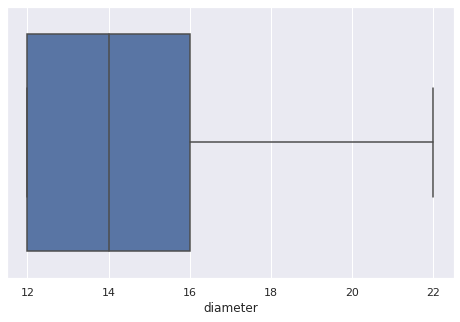

In [15]:
temp = df[df["diameter"] > Lower_whisk]
sns.boxplot(temp["diameter"])
plt.show()

### Zscore 

In [16]:
z=np.abs(stats.zscore(df["diameter"]))
threshold=3
print(np.where(z>3))

(array([], dtype=int64),)


**Zscore shows no outliers so I'll go with the actual dataset**

### Model Evaluation

In [17]:
X = df.drop("price",axis = 1)
Y = df["price"]

In [18]:
xtrain, xtest, ytrain, ytest = train_test_split(X,Y, test_size = 0.1, random_state =0) 

### Linear Regression

In [19]:
Linearmodel = LinearRegression()

#### Training 

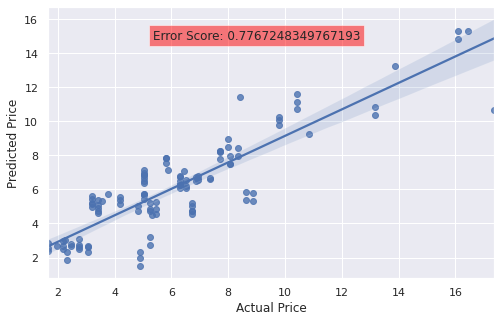

In [20]:
Linearmodel.fit(xtrain,ytrain)
Train_prediction = Linearmodel.predict(xtrain)
Li_Train_error_score = metrics.r2_score(ytrain, Train_prediction)

#Visualizing the plot
sns.regplot(x = ytrain, y = Train_prediction)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.text(9, 15, f'Error Score: {Li_Train_error_score}', horizontalalignment='center',verticalalignment='center'
         ,bbox=dict(facecolor='red', alpha=0.5))

plt.show()

#### Testing

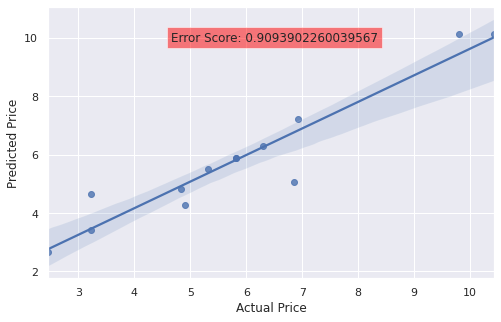

In [21]:
Linearmodel.fit(xtest,ytest)
Test_prediction = Linearmodel.predict(xtest)
Li_Test_error_score = metrics.r2_score(ytest, Test_prediction)

sns.regplot(x = ytest, y = Test_prediction)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.text(6.5, 10, f'Error Score: {Li_Test_error_score}', horizontalalignment='center',verticalalignment='center'
         ,bbox=dict(facecolor='red', alpha=0.5))

plt.show()

### Lasso Regression

In [22]:
Lassomodel = Lasso()

#### Train

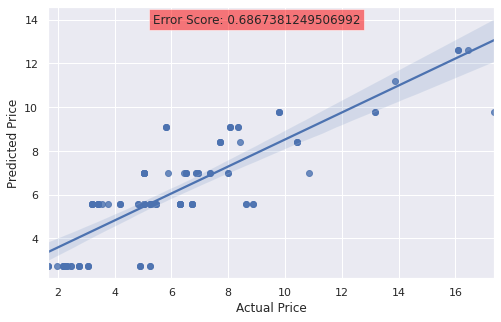

In [23]:
Lassomodel.fit(xtrain,ytrain)
Train_prediction = Lassomodel.predict(xtrain)
Lasso_Train_error_score = metrics.r2_score(ytrain, Train_prediction)
sns.regplot(x = ytrain, y = Train_prediction)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")

plt.text(9, 14, f'Error Score: {Lasso_Train_error_score}', horizontalalignment='center',verticalalignment='center'
         ,bbox=dict(facecolor='red', alpha=0.5))

plt.show()

#### Test

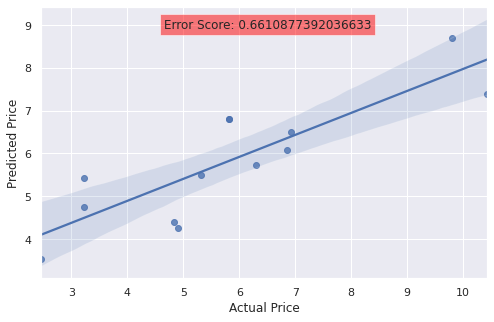

In [24]:
Lassomodel.fit(xtest,ytest)
Test_prediction = Lassomodel.predict(xtest)
Lasso_Test_error_score = metrics.r2_score(ytest, Test_prediction)

sns.regplot(x = ytest, y = Test_prediction)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.text(6.5, 9, f'Error Score: {Lasso_Test_error_score}', horizontalalignment='center',verticalalignment='center'
         ,bbox=dict(facecolor='red', alpha=0.5))

plt.show()

### XGBRegressor

In [25]:
XGBReg_model = XGBRegressor()

#### Train

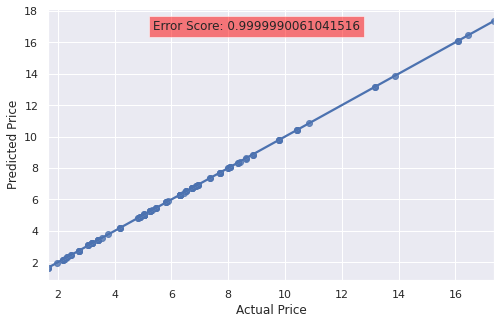

In [26]:
XGBReg_model.fit(xtrain,ytrain)
Train_prediction = XGBReg_model.predict(xtrain)
XGB_Train_error_score = metrics.r2_score(ytrain, Train_prediction)

sns.regplot(x = ytrain, y = Train_prediction)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.text(9, 17, f'Error Score: {XGB_Train_error_score}', horizontalalignment='center',verticalalignment='center'
         ,bbox=dict(facecolor='red', alpha=0.5))

plt.show()

#### Test

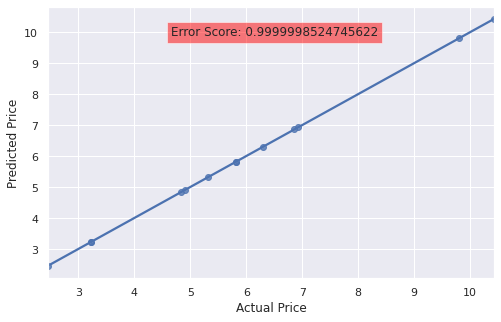

In [27]:
XGBReg_model.fit(xtest,ytest)
Test_prediction = XGBReg_model.predict(xtest)
XGB_Test_error_score = metrics.r2_score(ytest, Test_prediction)

sns.regplot(x = ytest, y = Test_prediction)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.text(6.5, 10, f'Error Score: {XGB_Test_error_score}', horizontalalignment='center',verticalalignment='center'
         ,bbox=dict(facecolor='red', alpha=0.5))

plt.show()

In [28]:
print("Linear Regression")
print(f'The R-Squared Value for Linear Regression Train Model is :{Li_Train_error_score}')
print(f'The R-Squared Value for Linear Regression Test Model is :{Li_Test_error_score}')

print()
print("Lasso Regression")
print(f'The R-Squared Value for Lasso Regression Train Model is :{Lasso_Train_error_score}')
print(f'The R-Squared Value for Lasso Regression Test Model is :{Lasso_Test_error_score}')

print()
print("XGBRegressor")
print(f'The R-Squared Value for XGBRegressor Train Model is :{XGB_Train_error_score}')
print(f'The R-Squared Value for XGBRegressor TestModel is :{XGB_Test_error_score}')

Linear Regression
The R-Squared Value for Linear Regression Train Model is :0.7767248349767193
The R-Squared Value for Linear Regression Test Model is :0.9093902260039567

Lasso Regression
The R-Squared Value for Lasso Regression Train Model is :0.6867381249506992
The R-Squared Value for Lasso Regression Test Model is :0.6610877392036633

XGBRegressor
The R-Squared Value for XGBRegressor Train Model is :0.9999990061041516
The R-Squared Value for XGBRegressor TestModel is :0.9999998524745622


### Conclusion

**XGBRegressor has better R-squared values thus it has better prediction score compared to Linear Regression model and Lass**

**Thank You!!!**